**Problem Statement:** Develop a fraud analytics model that help to detect fraud from good and normal user activity and create measures for reaction.

**Data Set:** Anonymized synthetic data set

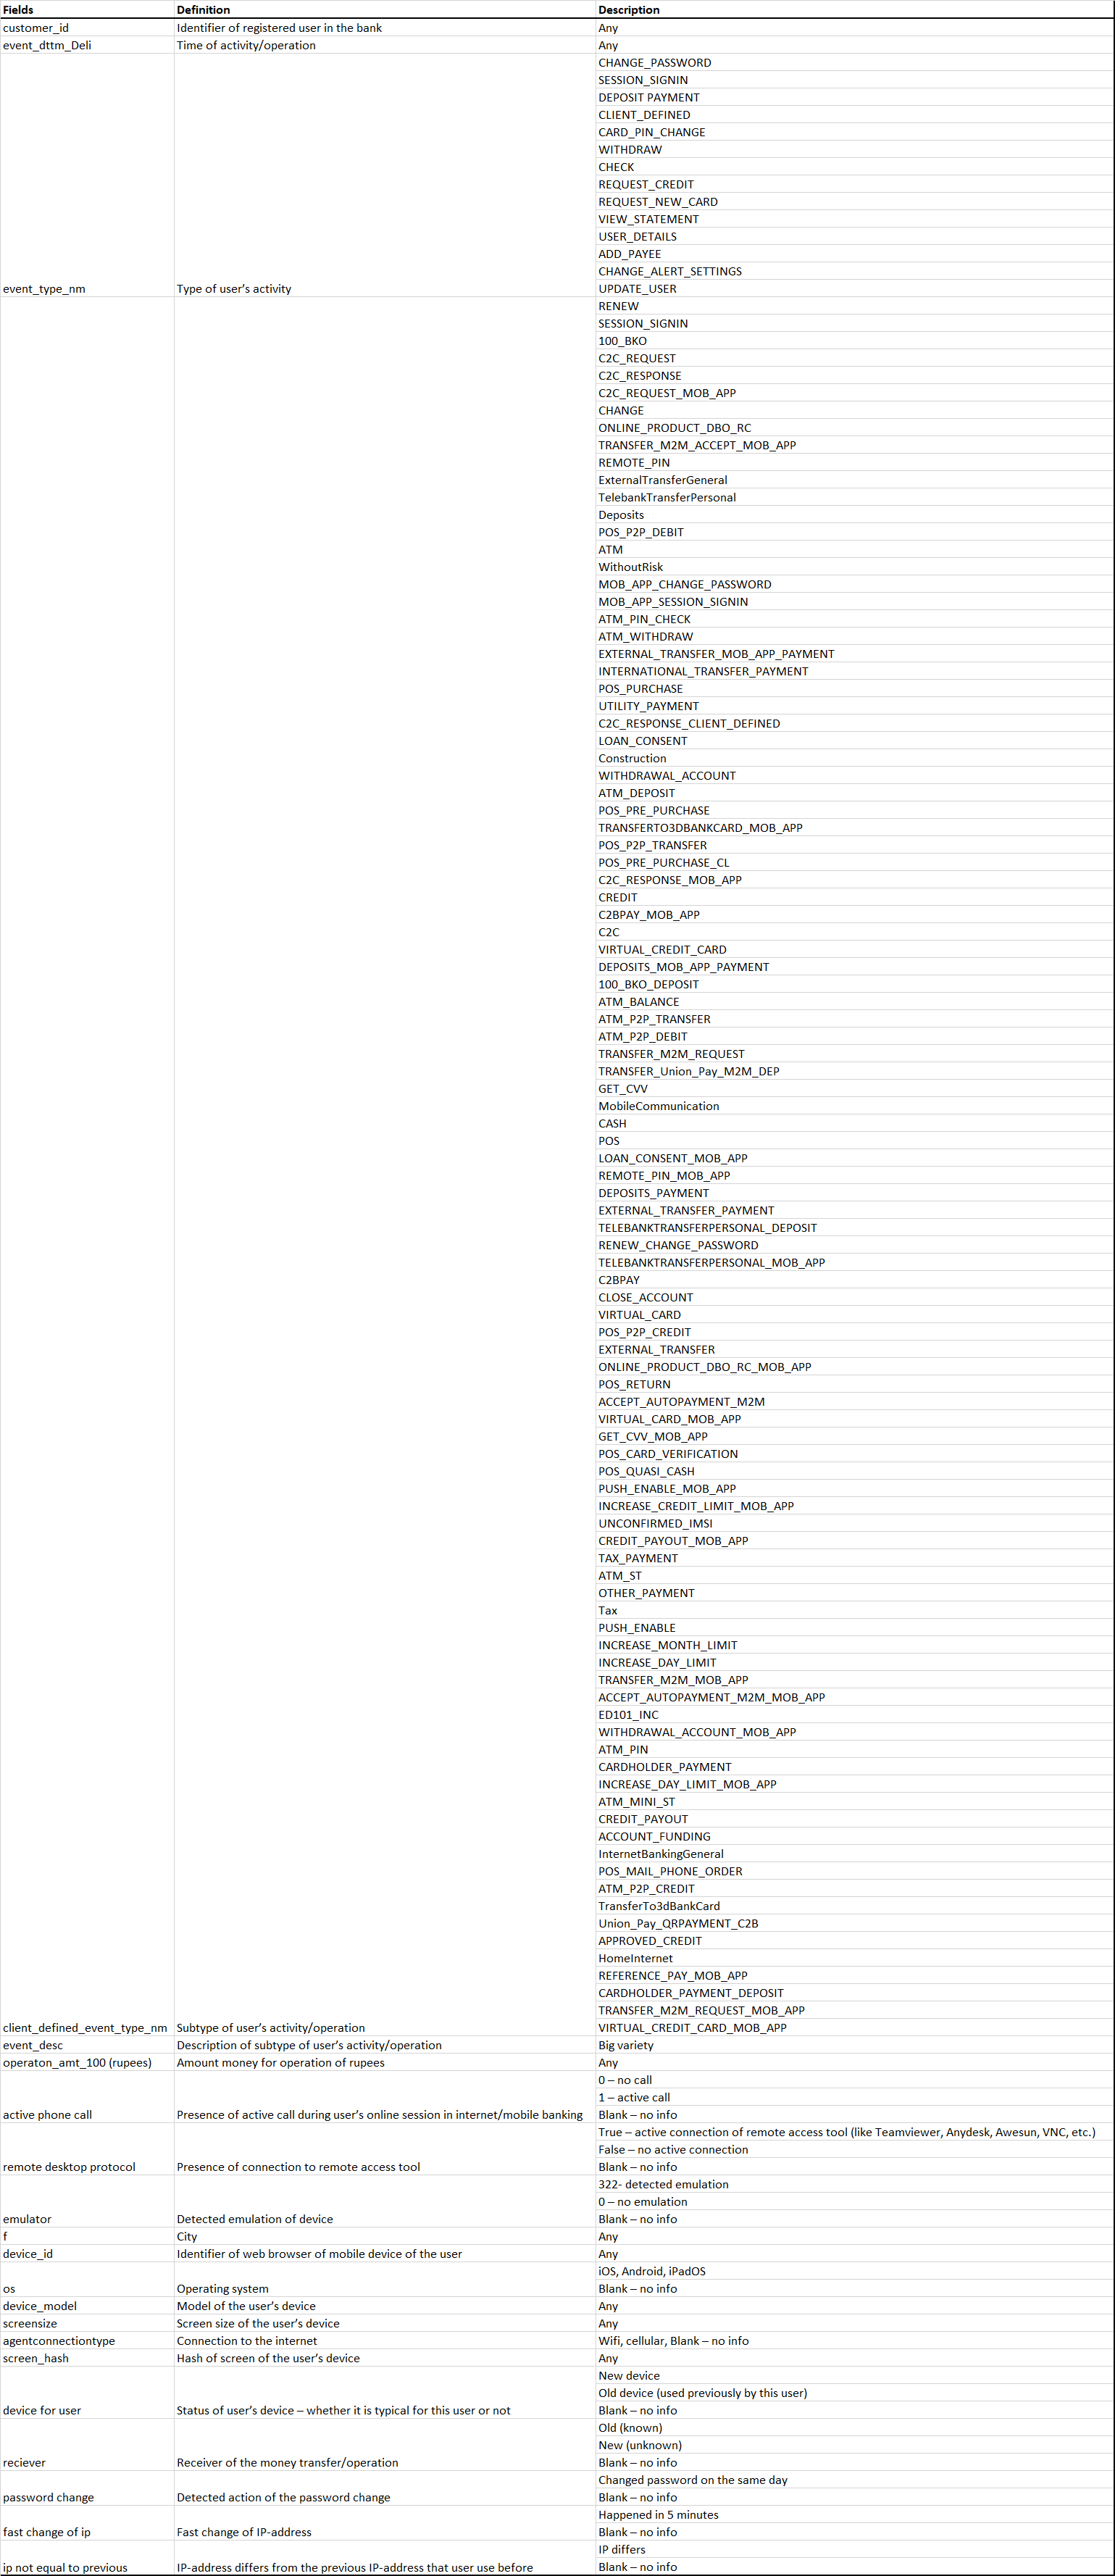

# Import libraries

In [ ]:
import numpy as np 
import pandas as pd
import re
import matplotlib.pyplot as plt

# Read dataset

In [ ]:
df = pd.read_excel('Dataset_Datathon_Fraud_Detection_28122022.xlsx')

In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df

In [ ]:
pd.reset_option('display.max_columns')

# Rename columns

In [ ]:
df.columns = [(('_'.join(c.split())).replace('(', '')).replace(')', '') for c in df.columns]

In [ ]:
df.columns

# Check data

In [ ]:
df.info()

# Distribution of categorical and numeric columns

In [ ]:
df.nunique()

In [ ]:
df.describe()

In [ ]:
pd.set_option('display.max_rows', None)
df['screen_hash'].value_counts()

In [ ]:
pd.reset_option('display.max_rows')

# Missing values
##### Numeric
- active_phone_call: missing = 0
- remote_desktop_protokol: missing = 0
- emulator: missing = 1
- screen_hash: missing = 0

##### Non-numeric
- *blank*

In [ ]:
values = {'active_phone_call': 0, 'remote_desktop_protokol': 0, 'emulator': 1, 'screen_hash': 0}
df.fillna(value=values, inplace=True)
df.fillna('', inplace=True)

In [ ]:
for c in ['event_type_nm', 'client_defined_event_type_nm', 'f', 'device_model', 'screensize', 
          'screen_hash', 'agentconnectiontype', 'device_for_user', 'reciever']:
    df[c].value_counts().plot.bar(figsize=(20,8))
    plt.title(c)
    plt.show()

In [ ]:
df['pre_auth_flag'] = df['event_desc'].str.lower().str.contains('authorization')
df['pre_auth_amount'] = df.apply(lambda x: x['operaton_amt_100_rupees'] if x['pre_auth_flag'] else 0, axis=1)

# Session slicing

In [ ]:
df.sort_values(['customer_id', 'event_dttm_Deli'], inplace=True)
df['new_session'] = (df['event_type_nm'] == 'SESSION_SIGNIN').astype(int)
df['session_num'] = df.groupby('customer_id')['new_session'].cumsum()
df.drop(['new_session'], axis=1, inplace=True)

In [ ]:
df

In [ ]:
session_df = df\
    .groupby(['customer_id','session_num']).agg(
                timestamp_min = ('event_dttm_Deli', 'min'),
                timestamp_max = ('event_dttm_Deli', 'max'),
                event_type_count = ('event_type_nm', 'count'),
                event_desc = ('event_desc', lambda x: ','.join(x)),
                amount_sum = ('operaton_amt_100_rupees', 'sum'),
                curr_device = ('device_model', lambda x: x.value_counts().index[0]),
                curr_location = ('f', lambda x: x.value_counts().index[0]),
                pre_auth_count = ('pre_auth_flag', 'sum'),
                pre_auth_amt = ('pre_auth_amount', 'sum'))

In [ ]:
session_df.reset_index(inplace=True)

In [ ]:
session_df['session_duration'] = (session_df['timestamp_max'] - session_df['timestamp_min']).astype('timedelta64[s]')
session_df['event_desc'] = session_df['event_desc'].str.lower()
session_df['event_desc_flag'] = session_df['event_desc'].str.contains('password') & (session_df['event_desc'].str.contains('payment') | session_df['event_desc'].str.contains('purchase'))

In [ ]:
session_df

# Customer profiling

In [ ]:
from statistics import mean,mode,stdev

customer_df = df.fillna('').groupby(['customer_id']).agg(
    amount_stdev = ('operaton_amt_100_rupees',stdev),amount_mean = ('operaton_amt_100_rupees','mean'),device = ('device_model',max),operating_sys = ('os','max'),location = ('f','max') 
)

# Merge Customer with Session

In [ ]:
df_merged = pd.merge(session_df, customer_df, left_on='customer_id', right_on='customer_id', how='left')

df_merged['amount_flag'] = df_merged['amount_sum'] > df_merged['amount_stdev'] 

In [ ]:
df_merged['device_flag'] = df_merged['curr_device'] != df_merged['device']
df_merged['location_flag'] = df_merged['curr_location'] != df_merged['location'] 

In [ ]:
pd.set_option('display.max_columns', None)
df_merged

In [ ]:
pd.reset_option('display.max_columns')

In [ ]:
df_final = df_merged[['customer_id','session_num','event_type_count','pre_auth_count','pre_auth_amt','session_duration','event_desc_flag','amount_stdev','amount_mean','amount_flag','device_flag','location_flag']].copy()
df_final.set_index(['customer_id','session_num'], inplace=True)

In [ ]:
df_final

In [ ]:
Rules :
    if pre_auth count greater than 1 or pre_auth amt greater than amount_stddev
    if event_desc flag and amount_flag
        fraudulent
    if  (even_desc_flag and  not amount_flag) or (amount_flag and (device_flag or location_flag))
        high chances of fradulent
    if device_flag or location_flag or amount_flag or pre_auth_count == 1
        to review

In [ ]:
condtitions = ((df_final['pre_auth_count'] > 1) | (df_final['pre_auth_amt'] > df_final['amount_stdev'])) |\
    (df_final['event_desc_flag'] & df_final['amount_flag']),\
    (df_final['event_desc_flag'] & ~df_final['amount_flag']) | ((df_final['amount_flag'] > 1) & (df_final['device_flag'] | df_final['location_flag'])),\
    ((df_final['event_desc_flag']) | (df_final['location_flag']) | (df_final['amount_flag']) | (df_final['pre_auth_count'] >1))

In [ ]:
types = ['fraud','possible_fraud','to_review']

In [ ]:
df_final['transaction_label'] = np.select(condtitions,types)

In [ ]:
df_final['transaction_label'] = df_final['transaction_label'].replace('0','unknown')

In [ ]:
df_final['transaction_label'].value_counts()

In [ ]:
df_final

In [ ]:
from kmodes.kmodes import KModes
import plotly.graph_objects as go
from sklearn.metrics import silhouette_score

In [ ]:
%matplotlib inline
# Elbow curve to find optimal K
cost = []
K = range(1,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, verbose=1)
    kmode.fit_predict(df_final)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
%%time

score_opt = {}

for i in range(2, 10):
    kmode = KModes(n_clusters=3, init = "random", n_init = i, verbose=1)
    clusters = kmode.fit_predict(df_final)
    score_opt[i] = silhouette_score(df_final, clusters)
max(score_opt.values())

In [ ]:
print(f'Silhouette Score: {silhouette_score(df_final, clusters)}')